# Setting up the modules 

In [1]:
# common libraries
import sys, glob, random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# analysis related modules
from scipy.stats import entropy, spearmanr
from scipy import interp
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, roc_curve, auc
from sklearn.model_selection import KFold, GroupKFold
from collections import Counter

In [3]:
# keras modules
import tensorflow as tf
# from keras.models import load_model

from bert.tokenization import FullTokenizer

# from keras.preprocessing.text import text_to_word_sequence, Tokenizer
# from keras.preprocessing.sequence import pad_sequences

# from keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.utils import plot_model
import keras_tqdm
from livelossplot.keras import PlotLossesCallback

/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sjnam/anacond

In [4]:
# custom layers from external files
from layers.embeddings import BertLayer
from layers.attention import AttentionLayer
from models.build_models import *
from models.train_models import *
from utils.utils import *

In [5]:
# some option settings for Jupyter notebook and TF
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_colwidth', -1)
tf.logging.set_verbosity(tf.logging.ERROR)

# import cloze sentences 

In [6]:
try:
    from google import colab
    IN_COLAB = True
    # mount GoogleDrive for data and external resources
    colab.drive.mount('/content/drive')

    # download and install additional libraries
    !pip install keras_tqdm -q
    !pip install livelossplot -q
    
    
#     sys.path.append('./drive/My Drive/Colab Notebooks')  # append colab directory to Python kernel's path
    df_cloze = pd.read_pickle('./drive/My Drive/Colab Notebooks/dataset/cloze_df_scores_all3.pickle')
except:
    IN_COLAB = False
    df_cloze = pd.read_pickle('./dataset/cloze_df_scores_all3.pickle') # enter the local location of DSCoVAR sentence data

## preprocessing model inputs

In [7]:
# sentences_wttarg = proc_sentences(df_cloze, 'sentence', 'syn1')
# sentences_notarg = proc_sentences(df_cloze, 'sentence', None)
sentences = proc_sentences_dscovar(df_cloze, 'sentence', 'targ', 'bert')

In [8]:
sentences

[array(['discord', 'rakish', 'defile', ..., 'deviate', 'frigid', 'adhere'],
       dtype='<U12'),
 array([' A discord  emerged between the two who were once friends . ',
        ' A bohemian is a person who is free-spirited and rakish  . ',
        ' A bunch of kids had broken in and defile  the paintings . ', ...,
        ' You will not get lost if you stay straight and do not deviate  . ',
        " You'll find what you're looking for when it becomes more frigid  . ",
        " Your plan's nice, but I doubt I could adhere  to it for long . "],
       dtype='<U109')]

In [9]:
mm_scaler = MinMaxScaler()

resp_scores = mm_scaler.fit_transform(df_cloze[['ent_cloze', 
                                                'elmo_score', 'bert_score', 'glove_score',
                                                'scores_sum', 'sent_len']])
resp_lex = resp_scores[:, 0]
resp_lex = 1-resp_lex # reversing the direction: high score for high informative sentences

resp_brt = resp_scores[:, 1]
resp_lmo = resp_scores[:, 2]
resp_glv = resp_scores[:, 3]
resp_bws = resp_scores[:, 4]
sent_len = resp_scores[:, 5]

/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


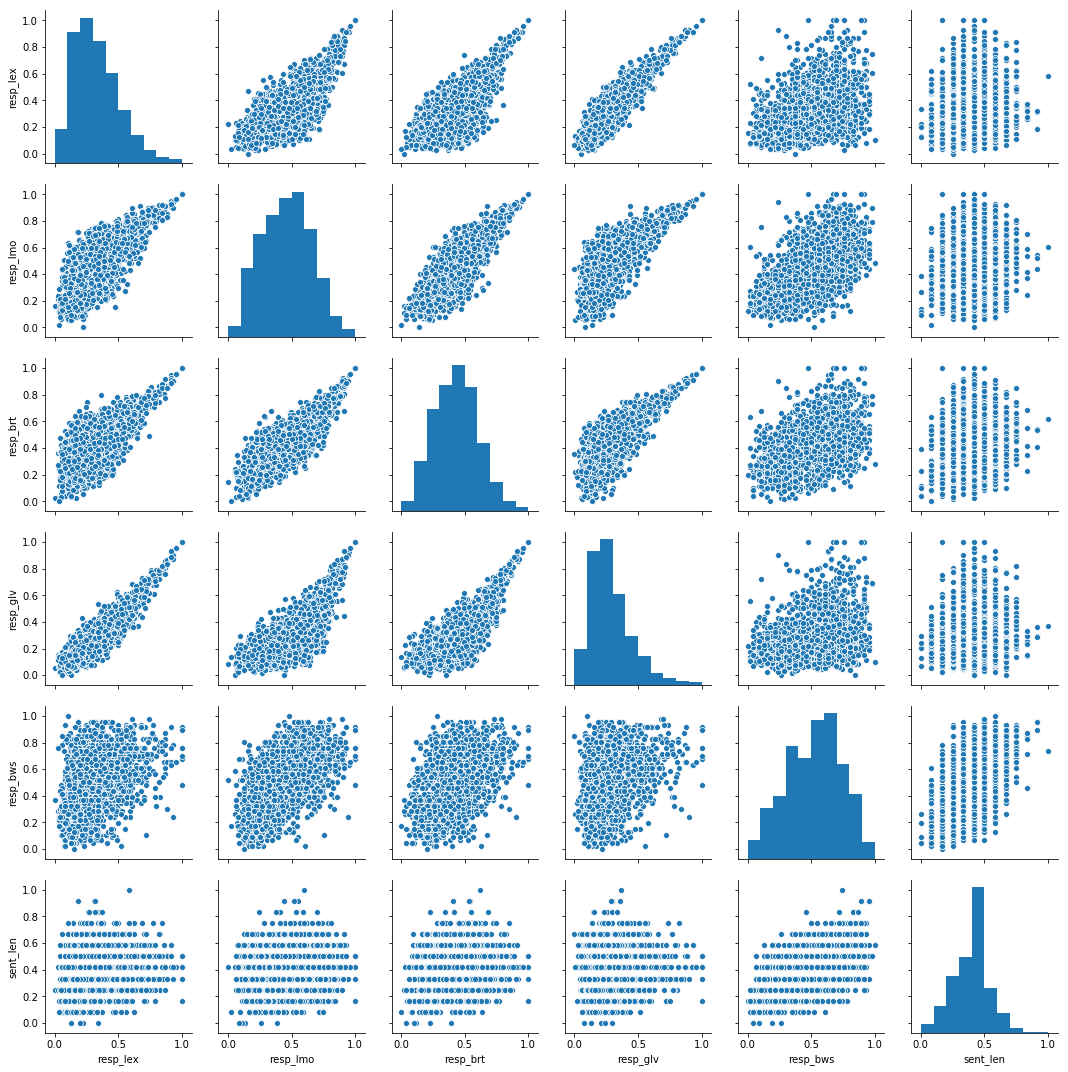

In [10]:
sns.pairplot(pd.DataFrame({"resp_lex":resp_lex, 
                           "resp_lmo":resp_lmo, "resp_brt":resp_brt, "resp_glv":resp_glv, 
                           "resp_bws":resp_bws,
                           "sent_len":sent_len}))

In [11]:
tokenizer = create_tokenizer_from_hub_module()
train_examples = convert_text_to_examples(sentences[0], sentences[1], resp_bws)
tt = convert_examples_to_features(tokenizer, train_examples[:1], False, MAX_SEQ_LEN)
tt[:4]

(array([[ 138,  103, 5338, 1206, 1103, 1160, 1150, 1127, 1517, 2053,  119,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]),
 array([[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]))

# BERT + Attention model

## separate targ-cntx layers

In [12]:
K.clear_session()
sess = tf.Session()

model = build_model_bert(MAX_SEQ_LEN, finetune_emb=True, attention_layer=True, sep_cntx_targ=True)
initialize_vars(sess)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 30)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 30)]         0                                            
__________________________________________________________________________________________________
bert_targ_raw (BertLayer)       (None, None, 768)    107719680   input_ids[0][0]                  
                                                                 input_masks[0][0]            

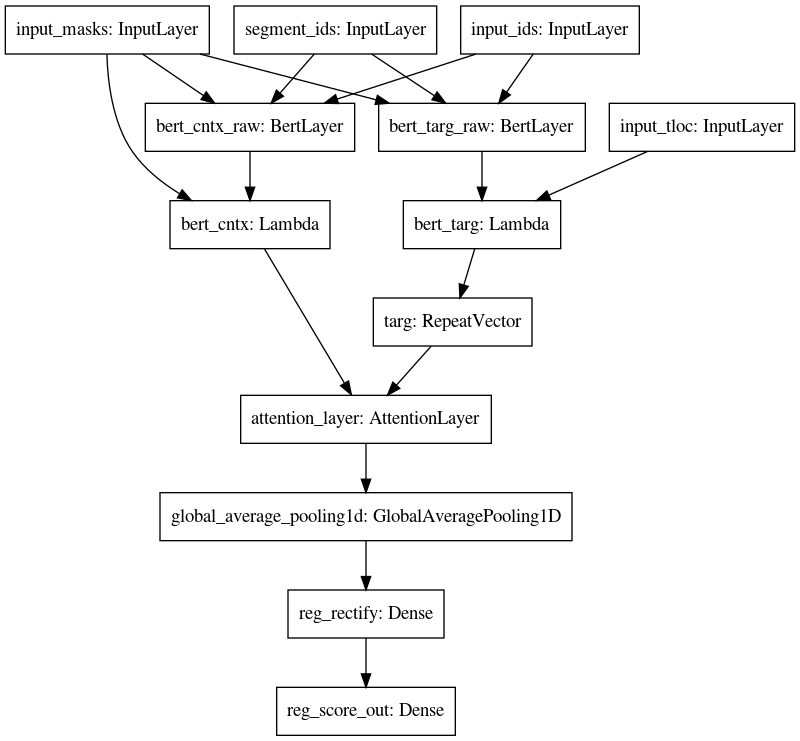

In [13]:
plot_model(model)

## Single targ-cntx layers

In [14]:
K.clear_session()
sess = tf.Session()

model = build_model_bert(MAX_SEQ_LEN, finetune_emb=False, attention_layer=True, sep_cntx_targ=False)
initialize_vars(sess)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 30)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 30)]         0                                            
__________________________________________________________________________________________________
bert_sent_raw (BertLayer)       (None, None, 768)    107719680   input_ids[0][0]                  
                                                                 input_masks[0][0]            

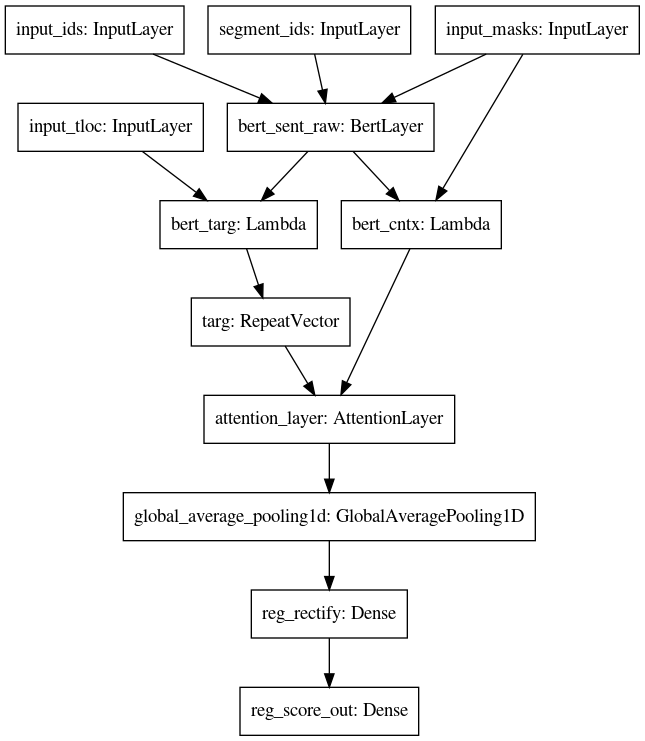

In [15]:
plot_model(model)

# K-fold training and predictions 

In [16]:
# target word location categories
targ_loc_cat = []
for i in range(df_cloze.shape[0]):
    if(df_cloze['targ_loc_end'][i]): 
        targ_loc_cat.append('3_last')
    else:
        if(df_cloze['targ_loc_rel'][i] <= 0.5):
            targ_loc_cat.append('0_less_50')
        elif((df_cloze['targ_loc_rel'][i] > 0.5)&(df_cloze['targ_loc_rel'][i] <= 0.65)):
            targ_loc_cat.append("1_(50_65]")
        elif((df_cloze['targ_loc_rel'][i] > 0.65)):
            targ_loc_cat.append("2_more_65")            

In [17]:
Counter(targ_loc_cat)

Counter({'0_less_50': 402, '3_last': 777, '2_more_65': 306, '1_(50_65]': 298})

In [18]:
sent_len_cat = pd.qcut(sent_len, [0, 0.20, 0.40, 0.60, 0.80, 1])
sent_len_cat.value_counts()

(-0.001, 0.25]    428
(0.25, 0.333]     351
(0.333, 0.417]    343
(0.417, 0.5]      330
(0.5, 1.0]        331
dtype: int64

In [19]:
# fold settings
gkf1 = GroupKFold(n_splits=K_FOLDS) ## target words
gkf2 = GroupKFold(n_splits=len(Counter(targ_loc_cat))) ## target word locations
gkf3 = GroupKFold(n_splits=len(sent_len_cat.value_counts())) ## sentence length

# Fitted to: BWS 

## fold: target words

In [22]:
X = sentences
y = resp_bws
y_type = 'bws'

## /w attention (finetune BERT)

In [17]:
NUM_ITER = [2,3,5]
LEARNING_RATE = [1e-3, 1e-4, 5e-5, 3e-5, 1e-5]
BATCH_SIZE = [16, 32]

### 1emb 

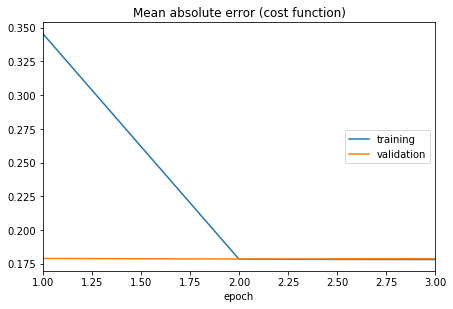

Mean absolute error (cost function):
training   (min:    0.178, max:    0.345, cur:    0.178)
validation (min:    0.178, max:    0.179, cur:    0.179)




fold: 4


In [ ]:
# _l_rate = 5e-5
# _num_iter = 3
# _batch_size = 16

for _l_rate in LEARNING_RATE:
    for _batch_size in BATCH_SIZE:
        for _num_iter in NUM_ITER:
            gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])
            train_bertmod_cv(X, y, False,
                             gkf_split, True, True, False, 
                             "./model_weights/finetune/bert/1emb/model_bert_notarg_wtattn_"+y_type+"_cvTwrd"+"_i"+str(_num_iter)+"_b"+str(_batch_size)+"_lr"+str(_l_rate),
                             "./model_predict/finetune/bert/1emb/preds_bert_notarg_wtattn_"+y_type+"_cvTwrd"+"_i"+str(_num_iter)+"_b"+str(_batch_size)+"_lr"+str(_l_rate),
                             MAX_SEQ_LEN, _l_rate, _num_iter, _batch_size)

### 2emb 

In [23]:
NUM_ITER = [2,3,5]
LEARNING_RATE = [5e-5, 3e-5, 1e-5]
BATCH_SIZE = [16] #32: OOM error

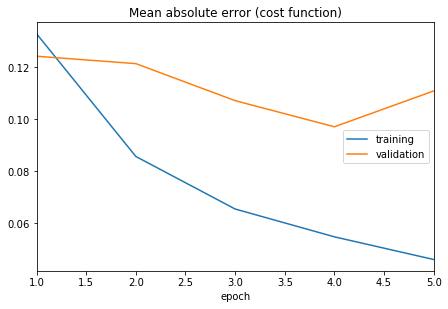

Mean absolute error (cost function):
training   (min:    0.046, max:    0.133, cur:    0.046)
validation (min:    0.097, max:    0.124, cur:    0.111)



In [24]:
for _l_rate in LEARNING_RATE:
    for _batch_size in BATCH_SIZE:
        for _num_iter in NUM_ITER:
            gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])
            train_bertmod_cv(X, y, False,
                             gkf_split, True, True, True, 
                             "./model_weights/finetune/bert/2emb/model_bert_notarg_wtattn_"+y_type+"_cvTwrd"+"_i"+str(_num_iter)+"_b"+str(_batch_size)+"_lr"+str(_l_rate),
                             "./model_predict/finetune/bert/2emb/preds_bert_notarg_wtattn_"+y_type+"_cvTwrd"+"_i"+str(_num_iter)+"_b"+str(_batch_size)+"_lr"+str(_l_rate),
                             MAX_SEQ_LEN, _l_rate, _num_iter, _batch_size)

# Classification performance 

In [26]:
sraw_test_cvTwrd = []
sraw_test_cvTloc = []
sraw_test_cvSlen = []

sent_test_cvTwrd = []
sent_test_cvTloc = []
sent_test_cvSlen = []
sent_test_cvTwrd2 = []
sent_test_cvTloc2 = []
sent_test_cvSlen2 = []

resp_bws_cvTwrd = [] 
resp_bws_cvTloc = [] 
resp_bws_cvSlen = [] 
resp_lex_cvTwrd = [] 
resp_lex_cvTloc = [] 
resp_lex_cvSlen = [] 
resp_brt_cvTwrd = [] 
resp_brt_cvTloc = [] 
resp_brt_cvSlen = [] 

for train_idx, test_idx in gkf1.split(df_cloze['sentence'], groups=df_cloze['targ']):
    tt_sents = [sent[test_idx] for sent in sentences]
    sraw_test_cvTwrd.append(tt_sents)
    tt_bws = [resp_bws[i] for i in test_idx]
    tt_brt = [resp_brt[i] for i in test_idx]
    tt_lex = [resp_lex[i] for i in test_idx]
    resp_bws_cvTwrd.append(tt_bws)
    resp_brt_cvTwrd.append(tt_brt)
    resp_lex_cvTwrd.append(tt_lex)
    tt_cvTwrd = convert_text_to_examples(tt_sents[0], tt_sents[1], tt_bws)
    
    sent_test_cvTwrd.append(convert_examples_to_features(tokenizer, tt_cvTwrd, True, MAX_SEQ_LEN))
    sent_test_cvTwrd2.append(convert_examples_to_features(tokenizer, tt_cvTwrd, False, MAX_SEQ_LEN))
    
for train_idx, test_idx in gkf2.split(df_cloze['sentence'], groups=targ_loc_cat):
    tt_sents = [sent[test_idx] for sent in sentences]
    sraw_test_cvTloc.append(tt_sents)
    tt_bws = [resp_bws[i] for i in test_idx]
    tt_brt = [resp_brt[i] for i in test_idx]
    tt_lex = [resp_lex[i] for i in test_idx]
    resp_bws_cvTloc.append(tt_bws)
    resp_brt_cvTloc.append(tt_brt)
    resp_lex_cvTloc.append(tt_lex)
    tt_cvTloc = convert_text_to_examples(tt_sents[0], tt_sents[1], tt_bws)
    
    sent_test_cvTloc.append(convert_examples_to_features(tokenizer, tt_cvTloc, True, MAX_SEQ_LEN))
    sent_test_cvTloc2.append(convert_examples_to_features(tokenizer, tt_cvTloc, False, MAX_SEQ_LEN))
    
for train_idx, test_idx in gkf3.split(df_cloze['sentence'], groups=sent_len_cat):
    tt_sents = [sent[test_idx] for sent in sentences]
    sraw_test_cvSlen.append(tt_sents)
    tt_bws = [resp_bws[i] for i in test_idx]
    tt_brt = [resp_brt[i] for i in test_idx]
    tt_lex = [resp_lex[i] for i in test_idx]
    resp_bws_cvSlen.append(tt_bws)
    resp_brt_cvSlen.append(tt_brt)
    resp_lex_cvSlen.append(tt_lex)
    tt_cvSlen = convert_text_to_examples(tt_sents[0], tt_sents[1], tt_bws)
    
    sent_test_cvSlen.append(convert_examples_to_features(tokenizer, tt_cvSlen, True, MAX_SEQ_LEN))
    sent_test_cvSlen2.append(convert_examples_to_features(tokenizer, tt_cvSlen, False, MAX_SEQ_LEN))

## CV over target words vs. target word location

In [27]:
Counter(targ_loc_cat)

Counter({'0_less_50': 402, '3_last': 777, '2_more_65': 306, '1_(50_65]': 298})

In [28]:
sent_len_cat.value_counts()

(-0.001, 0.25]    428
(0.25, 0.333]     351
(0.333, 0.417]    343
(0.417, 0.5]      330
(0.5, 1.0]        331
dtype: int64

### fitted to: BWS score
- target location may bias the prediction results in some cases, but not by much
- sentence length may be the problem
- attention layer improve the performance
    - both with/w.o. target word conditions
- NOT including the target word (synonym of the original) improves the performance
- Attention improves the performance
    - attention captures: the relationship between the target (known or unknown) and context

Text(0.5,1,'iter: 2; batch: 16')

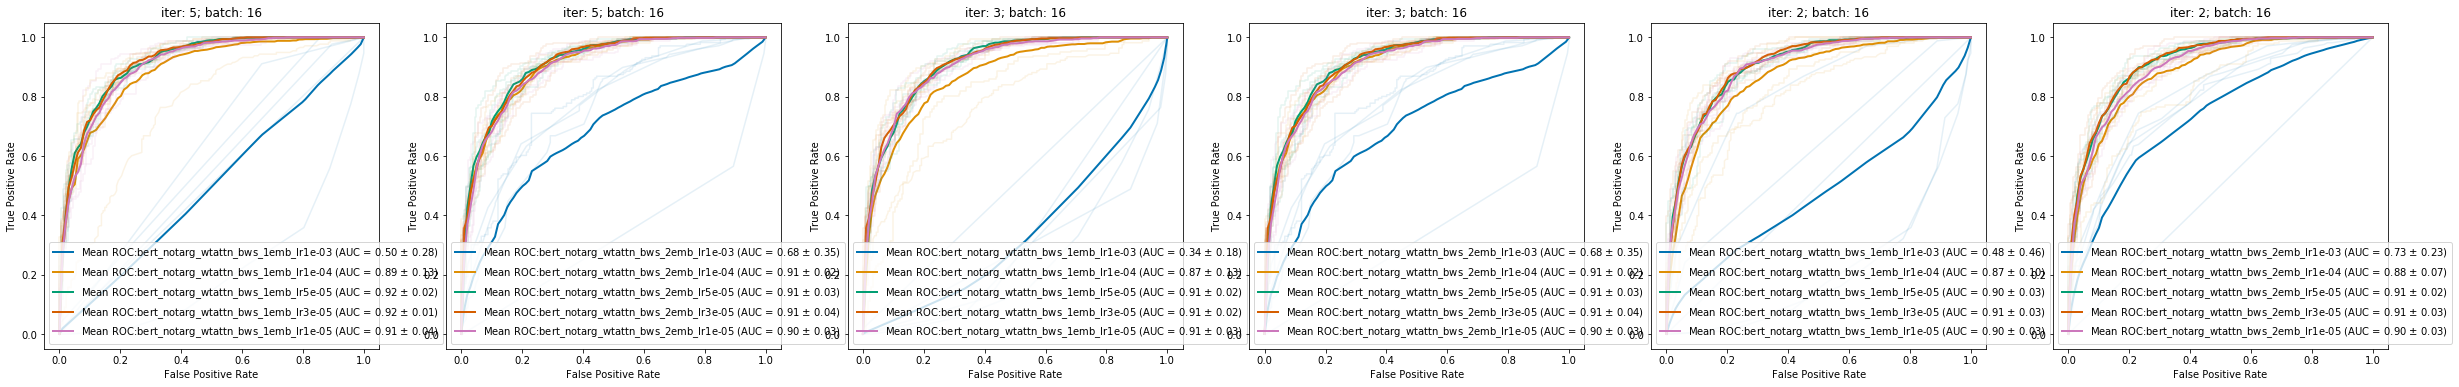

In [33]:
fig, axes = plt.subplots(ncols=6, figsize=(42, 6))
tt_col = sns.color_palette("colorblind", 6)

# iter: 5; batch: 16
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/1emb/preds_bert_notarg_wtattn_bws_cvTwrd_i5_b16_lr0.001*",  "bert_notarg_wtattn_bws_1emb_lr1e-03", 0.50, "high", fig, axes[0], tt_col[0], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/1emb/preds_bert_notarg_wtattn_bws_cvTwrd_i5_b16_lr0.0001*", "bert_notarg_wtattn_bws_1emb_lr1e-04", 0.50, "high", fig, axes[0], tt_col[1], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/1emb/preds_bert_notarg_wtattn_bws_cvTwrd_i5_b16_lr5e-05*",  "bert_notarg_wtattn_bws_1emb_lr5e-05", 0.50, "high", fig, axes[0], tt_col[2], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/1emb/preds_bert_notarg_wtattn_bws_cvTwrd_i5_b16_lr3e-05*",  "bert_notarg_wtattn_bws_1emb_lr3e-05", 0.50, "high", fig, axes[0], tt_col[3], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/1emb/preds_bert_notarg_wtattn_bws_cvTwrd_i5_b16_lr1e-05*",  "bert_notarg_wtattn_bws_1emb_lr1e-05", 0.50, "high", fig, axes[0], tt_col[4], '-')

# iter: 5; batch: 16
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/2emb/preds_bert_notarg_wtattn_bws_cvTwrd_i3_b16_lr0.001*",  "bert_notarg_wtattn_bws_2emb_lr1e-03", 0.50, "high", fig, axes[1], tt_col[0], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/2emb/preds_bert_notarg_wtattn_bws_cvTwrd_i3_b16_lr0.0001*", "bert_notarg_wtattn_bws_2emb_lr1e-04", 0.50, "high", fig, axes[1], tt_col[1], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/2emb/preds_bert_notarg_wtattn_bws_cvTwrd_i3_b16_lr5e-05*",  "bert_notarg_wtattn_bws_2emb_lr5e-05", 0.50, "high", fig, axes[1], tt_col[2], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/2emb/preds_bert_notarg_wtattn_bws_cvTwrd_i3_b16_lr3e-05*",  "bert_notarg_wtattn_bws_2emb_lr3e-05", 0.50, "high", fig, axes[1], tt_col[3], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/2emb/preds_bert_notarg_wtattn_bws_cvTwrd_i3_b16_lr1e-05*",  "bert_notarg_wtattn_bws_2emb_lr1e-05", 0.50, "high", fig, axes[1], tt_col[4], '-')

# iter: 3: batch: 16
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/1emb/preds_bert_notarg_wtattn_bws_cvTwrd_i3_b16_lr0.001*",  "bert_notarg_wtattn_bws_1emb_lr1e-03", 0.50, "high", fig, axes[2], tt_col[0], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/1emb/preds_bert_notarg_wtattn_bws_cvTwrd_i3_b16_lr0.0001*", "bert_notarg_wtattn_bws_1emb_lr1e-04", 0.50, "high", fig, axes[2], tt_col[1], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/1emb/preds_bert_notarg_wtattn_bws_cvTwrd_i3_b16_lr5e-05*",  "bert_notarg_wtattn_bws_1emb_lr5e-05", 0.50, "high", fig, axes[2], tt_col[2], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/1emb/preds_bert_notarg_wtattn_bws_cvTwrd_i3_b16_lr3e-05*",  "bert_notarg_wtattn_bws_1emb_lr3e-05", 0.50, "high", fig, axes[2], tt_col[3], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/1emb/preds_bert_notarg_wtattn_bws_cvTwrd_i3_b16_lr1e-05*",  "bert_notarg_wtattn_bws_1emb_lr1e-05", 0.50, "high", fig, axes[2], tt_col[4], '-')

# iter: 3; batch: 16
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/2emb/preds_bert_notarg_wtattn_bws_cvTwrd_i3_b16_lr0.001*",  "bert_notarg_wtattn_bws_2emb_lr1e-03", 0.50, "high", fig, axes[3], tt_col[0], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/2emb/preds_bert_notarg_wtattn_bws_cvTwrd_i3_b16_lr0.0001*", "bert_notarg_wtattn_bws_2emb_lr1e-04", 0.50, "high", fig, axes[3], tt_col[1], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/2emb/preds_bert_notarg_wtattn_bws_cvTwrd_i3_b16_lr5e-05*",  "bert_notarg_wtattn_bws_2emb_lr5e-05", 0.50, "high", fig, axes[3], tt_col[2], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/2emb/preds_bert_notarg_wtattn_bws_cvTwrd_i3_b16_lr3e-05*",  "bert_notarg_wtattn_bws_2emb_lr3e-05", 0.50, "high", fig, axes[3], tt_col[3], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/2emb/preds_bert_notarg_wtattn_bws_cvTwrd_i3_b16_lr1e-05*",  "bert_notarg_wtattn_bws_2emb_lr1e-05", 0.50, "high", fig, axes[3], tt_col[4], '-')

# iter: 2: batch: 16
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/1emb/preds_bert_notarg_wtattn_bws_cvTwrd_i2_b16_lr0.001*",  "bert_notarg_wtattn_bws_1emb_lr1e-03", 0.50, "high", fig, axes[4], tt_col[0], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/1emb/preds_bert_notarg_wtattn_bws_cvTwrd_i2_b16_lr0.0001*", "bert_notarg_wtattn_bws_1emb_lr1e-04", 0.50, "high", fig, axes[4], tt_col[1], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/1emb/preds_bert_notarg_wtattn_bws_cvTwrd_i2_b16_lr5e-05*",  "bert_notarg_wtattn_bws_1emb_lr5e-05", 0.50, "high", fig, axes[4], tt_col[2], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/1emb/preds_bert_notarg_wtattn_bws_cvTwrd_i2_b16_lr3e-05*",  "bert_notarg_wtattn_bws_1emb_lr3e-05", 0.50, "high", fig, axes[4], tt_col[3], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/1emb/preds_bert_notarg_wtattn_bws_cvTwrd_i2_b16_lr1e-05*",  "bert_notarg_wtattn_bws_1emb_lr1e-05", 0.50, "high", fig, axes[4], tt_col[4], '-')

# iter: 2; batch: 16
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/2emb/preds_bert_notarg_wtattn_bws_cvTwrd_i2_b16_lr0.001*",  "bert_notarg_wtattn_bws_2emb_lr1e-03", 0.50, "high", fig, axes[5], tt_col[0], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/2emb/preds_bert_notarg_wtattn_bws_cvTwrd_i2_b16_lr0.0001*", "bert_notarg_wtattn_bws_2emb_lr1e-04", 0.50, "high", fig, axes[5], tt_col[1], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/2emb/preds_bert_notarg_wtattn_bws_cvTwrd_i2_b16_lr5e-05*",  "bert_notarg_wtattn_bws_2emb_lr5e-05", 0.50, "high", fig, axes[5], tt_col[2], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/2emb/preds_bert_notarg_wtattn_bws_cvTwrd_i2_b16_lr3e-05*",  "bert_notarg_wtattn_bws_2emb_lr3e-05", 0.50, "high", fig, axes[5], tt_col[3], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/bert/2emb/preds_bert_notarg_wtattn_bws_cvTwrd_i2_b16_lr1e-05*",  "bert_notarg_wtattn_bws_2emb_lr1e-05", 0.50, "high", fig, axes[5], tt_col[4], '-')

axes[0].set_title("iter: 5; batch: 16")
axes[1].set_title("iter: 5; batch: 16")
axes[2].set_title("iter: 3; batch: 16")
axes[3].set_title("iter: 3; batch: 16")
axes[4].set_title("iter: 2; batch: 16")
axes[5].set_title("iter: 2; batch: 16")